# Fig. 4 calculation - except BOA, HC & LED

In [107]:
import numpy as np
import pandas as pd

from replearn.eventlog import EventLog

from replearn.embedding_predict import EmbeddingPredict
from replearn.autoencoder import AutoencoderRepresentation
from replearn.doc2vec import Doc2VecRepresentation

from replearn.clustering import Clustering
from replearn.evaluation import Evaluation
import os
    

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib


In [108]:
def getFilePaths(path_of_the_directory, noiselevel):
    filepaths = []
    for filename in os.listdir(path_of_the_directory):
        f = os.path.join(path_of_the_directory,filename)
        if os.path.isfile(f) and str(noiselevel) + "-1.json.gz" in f: 
            filepaths.append(f)
    return filepaths


# method def: Autoencoder = 1, Trace2Vec = 2, Case2Vec(event) = 3, Case2Vec(event+case) = 4, LSTMClust = 5, GRUClust = 6
def getMetrics_for_Method_and_Noise(noiselevel, method):
    
    filepaths = getFilePaths('../logs/multi-perspective_01', noiselevel)

    case_attributes = None # auto-detect attributes
    event_attributes = ['concept:name', 'user'] # use activity name and user
    true_cluster_label = 'cluster'

    # hyperparameters
    n_epochs = 25
    n_batch_size = 64
    n_clusters = 5

    vector_size = 32

    data = []
    
    for file in filepaths:

        # load file
        event_log = EventLog(file, case_attributes=case_attributes, event_attributes=event_attributes, true_cluster_label=true_cluster_label)
        event_log.load(file, False)
        event_log.preprocess()
        
        
        if method == 1:

            # get sequences from event log as one-hot feature vector
            sequences = event_log.event_attributes_flat_onehot_features_2d

            # init and train autoencoder
            autoencoder = AutoencoderRepresentation(event_log)
            autoencoder.build_model(sequences.shape[1], encoder_dim=vector_size)
            autoencoder.fit(batch_size=n_batch_size, epochs=n_epochs, verbose=True)

            # get feature vector
            feature_vector = autoencoder.predict()
        
        elif method == 2:
            
            doc2vec = Doc2VecRepresentation(event_log)
            doc2vec.build_model(append_case_attr=False, append_event_attr=False, vector_size=vector_size, concat=True, epochs=n_epochs)
            doc2vec.fit()
            
            # infer the vector from the model
            feature_vector = doc2vec.predict(epochs=50)
            
        elif method == 3:
            
            # train doc2vec model
            doc2vec = Doc2VecRepresentation(event_log)
            doc2vec.build_model(append_case_attr=False, append_event_attr=True, vector_size=vector_size, concat=True, epochs=n_epochs)
            doc2vec.fit()
            
            # infer the vector from the model
            feature_vector = doc2vec.predict(epochs=50)
            
        elif method == 4:
            
            doc2vec = Doc2VecRepresentation(event_log)
            doc2vec.build_model(append_case_attr=True, append_event_attr=True, vector_size=vector_size, concat=True, epochs=n_epochs)
            doc2vec.fit()

            # infer the vector from the model
            feature_vector = doc2vec.predict(epochs=50)
            
        elif method == 5:
            
            # init and train LSTM
            predictor = EmbeddingPredict(event_log)
            predictor.build_model(embedding_dim=vector_size, gru_dim=vector_size, rnn='LSTM')
            predictor.fit(epochs=n_epochs, batch_size=n_batch_size, verbose=True)

            # get feature vector
            pred_model, feature_vector, embedding_vector = predictor.predict()
            
        else:
            
            # init and train LSTM
            predictor = EmbeddingPredict(event_log)
            predictor.build_model(embedding_dim=vector_size, gru_dim=vector_size, rnn='gru')
            predictor.fit(epochs=n_epochs, batch_size=n_batch_size, verbose=True)

            # get feature vector
            pred_model, feature_vector, embedding_vector = predictor.predict()
            
        
        # cluster feature vector
        cluster_analysis = Clustering(event_log)
        cluster_analysis.cluster(feature_vector, 'agglomerative', n_clusters, 'cosine')

        evaluation_a = Evaluation(event_log)
        results = evaluation_a.evaluate_clusters(n_clusters,cluster_analysis._pred_labels)
        cluster_result = cluster_analysis.evaluate()
        
        # get results
        data.append({'avgFitness': results[0], 'avgPrecision': results[1], 'avgSimp': results[2], 'avgF1-BCubed': cluster_result[2], 'Noise': noiselevel, 'Method': method})
    
    return pd.DataFrame(data)



In [109]:
def getResults_all_Noise_levels(method):
    list = []
    noiseLevels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0
    for level in noiseLevels:
        list.append(getMetrics_for_Method_and_Noise(level, method))
    return list

def getCombinedMeanResults(method):
    allResults = getResults_all_Noise_levels(method)
    means = [pd.DataFrame(df.mean()).transpose() for df in allResults]
    df = pd.DataFrame({'avgFitness': [], 'avgPrecision': [], 'avgSimp': [], 'avgF1-BCubed': [], 'Noise': [], 'Method': []})
    for meanResults in means:
        df = df.append(meanResults, ignore_index=True)
    return df

In [111]:
# get Results and write into csv
#resultsAutoencoder = getCombinedMeanResults(1)
#resultsTrace2Vec = getCombinedMeanResults(2)
#resultsCase2Vec_event = getCombinedMeanResults(3)
#resultsCase2Vec_event_case = getCombinedMeanResults(4)
#resultsLSTMClust = getCombinedMeanResults(5)
resultsGRUClust = getCombinedMeanResults(6)

#resultsAutoencoder.to_csv('fig4_resultsAutoencoder.csv', encoding='utf-8', index=False, sep=';')
#resultsTrace2Vec.to_csv('fig4_resultsTrace2Vec.csv', encoding='utf-8', index=False, sep=';')
#resultsCase2Vec_event.to_csv('fig4_resultsCase2Vec_event.csv', encoding='utf-8', index=False, sep=';')
#resultsCase2Vec_event_case.to_csv('fig4_resultsCase2Vec_event_case.csv', encoding='utf-8', index=False, sep=';')
#resultsLSTMClust.to_csv('fig4_resultsLSTMClust.csv', encoding='utf-8', index=False, sep=';')
resultsGRUClust.to_csv('fig4_2018_resultsGRUClust.csv', encoding='utf-8', index=False, sep=';')

In [5]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    

def plotResults(results):
    
    plt_1 = plt.figure(figsize=(20, 16))
    
    fig, axs = plt.subplots(2, 2, figsize=(10,5))
    fig.tight_layout()
    
    for res in results:
        axs[0, 0].plot(res["data"]['Noise'], res["data"]['avgF1-BCubed'], label=res["method"], marker=res["marker"], color=res["color"])
        axs[0, 1].plot(res["data"]['Noise'], res["data"]['avgSimp'], label=res["method"], color=res["color"], marker=res["marker"])
        axs[1, 0].plot(res["data"]['Noise'], res["data"]['avgFitness'], label=res["method"], color=res["color"], marker=res["marker"])
        axs[1, 1].plot(res["data"]['Noise'], res["data"]['avgPrecision'], label=res["method"], color=res["color"], marker=res["marker"])
        
    axs[0, 0].grid()
    axs[0, 1].grid()
    axs[1, 0].grid()
    axs[1, 1].grid()
    
    axs[0, 0].spines['top'].set_visible(False)
    axs[0, 0].spines['right'].set_visible(False)
    axs[0, 1].spines['top'].set_visible(False)
    axs[0, 1].spines['right'].set_visible(False)
    axs[1, 0].spines['top'].set_visible(False)
    axs[1, 0].spines['right'].set_visible(False)
    axs[1, 1].spines['top'].set_visible(False)
    axs[1, 1].spines['right'].set_visible(False)

    axs[0, 0].set_xticks(np.arange(min(results[0]["data"]['Noise']), max(results[0]["data"]['Noise'])+1, 0.1))
    axs[0, 0].set_yticks(np.arange(min(results[0]["data"]['Noise']), max(results[0]["data"]['Noise'])+1, 0.2))
    axs[0, 0].set_ylim([0.38,1])
    axs[0, 0].set_xlim([0,1])
    axs[0, 0].set_ylabel('F1-BCubed')
    

    axs[0, 1].set_xticks(np.arange(min(results[0]["data"]['Noise']), max(results[0]["data"]['Noise'])+1, 0.1))
    axs[0, 1].set_yticks(np.arange(min(results[0]["data"]['Noise']), max(results[0]["data"]['Noise'])+1, 0.2))
    axs[0, 1].set_ylim([0.11,1])
    axs[0, 1].yaxis.set_label_position("right")
    axs[0, 1].set_xlim([0,1])
    axs[0, 1].set_ylabel('Simplicity')
    

    axs[1, 0].set_xticks(np.arange(min(results[0]["data"]['Noise']), max(results[0]["data"]['Noise'])+1, 0.1))
    axs[1, 0].set_yticks(np.arange(min(results[0]["data"]['Noise']), max(results[0]["data"]['Noise'])+1, 0.2))
    axs[1, 0].set_ylim([0.21,1])
    axs[1, 0].set_xlim([0,1])
    axs[1, 0].set_ylabel('Fitness')
    axs[1, 0].set_xlabel('noise')
    
    axs[1, 1].set_xticks(np.arange(min(results[0]["data"]['Noise']), max(results[0]["data"]['Noise'])+1, 0.1))
    axs[1, 1].set_yticks(np.arange(min(results[0]["data"]['Noise']), max(results[0]["data"]['Noise'])+1, 0.2))
    axs[1, 1].set_ylim([0.11, 0.9])
    axs[1, 1].set_xlim([0,1])
    axs[1, 1].set_ylabel('Precision')
    axs[1, 1].set_xlabel('noise')
    axs[1, 1].yaxis.set_label_position("right")

    
    handles, labels = axs[0, 0].get_legend_handles_labels()
    
    fig.legend(handles, labels, bbox_to_anchor=(0.85,-0.05), ncol=3)

    fig.savefig('fig4', bbox_inches='tight')

    plt.show()
    

In [6]:
# function to read in all the results
def readInResults():
    data = []
    data.append({"method": "Autoencoder", "marker": 'o', "color":'#40bfed', "data": pd.read_csv('fig4_agglo_2020_resultsAutoencoder.csv', sep = ';')})
    data.append({"method": "Trace2Vec", "marker": None, "color":'#0c5459', "data":pd.read_csv('fig4_agglo_2020_resultsTrace2Vec.csv', sep = ';')})
    data.append({"method": "Case2Vec (event)", "marker": 's', "color":'#ed9140', "data": pd.read_csv('fig4_agglo_2020_resultsCase2Vec_event.csv', sep = ';')})
    data.append({"method": "Case2Vec (event+case)", "marker": '|', "color":'#521275', "data":pd.read_csv('fig4_agglo_2020_resultsCase2Vec_event_case.csv', sep = ';')})
    data.append({"method": "GRUClust", "marker": 'x',"color":'#f28df7', "data":pd.read_csv('fig4_agglo_2020_resultsGRUClust.csv', sep = ';')})
    data.append({"method": "LSTMClust", "marker": None,"color":'#ba1318', "data":pd.read_csv('fig4_agglo_2020_resultsLSTMClust.csv', sep = ';')})

    
    return data

In [100]:
SMALL_SIZE = 12
matplotlib.rc('xtick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('axes', labelsize=16)
matplotlib.rc('legend', fontsize=16) 


<Figure size 1440x1152 with 0 Axes>

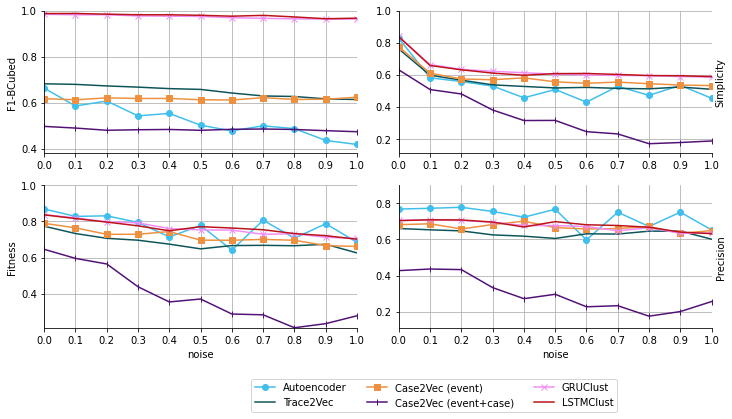

In [8]:
# read in and plot the Results
plotResults(readInResults())

## Fig 5

In [104]:
def plotFig5(results):
    plt_2 = plt.figure(figsize=(10, 5))
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    for res in results:
        res["data"]['F-Measure'] = (2 * res["data"]['avgFitness'] * res["data"]['avgPrecision'])/(res["data"]['avgFitness'] + res["data"]['avgPrecision'])
        ax.plot(res["data"]['Noise'], res["data"]['F-Measure'], label=res["method"], marker=res["marker"], color=res["color"])

    ax.set_ylabel('F-Score (Discovery)')
    ax.set_xlabel('noise')
    ax.set_xticks(np.arange(0, 1.01, 0.1))
    ax.set_yticks(np.arange(0.2, 1.01, 0.2))
    ax.grid()
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
    handles, labels = ax.get_legend_handles_labels()
    
    fig.legend(handles, labels, bbox_to_anchor=(1.2,1))
    
    fig.savefig('fig5', bbox_inches='tight')
    
    plt.show()

<Figure size 720x360 with 0 Axes>

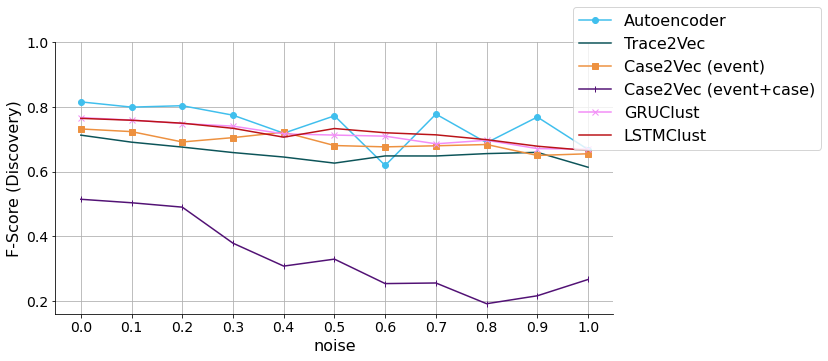

In [105]:
plotFig5(readInResults())